# <center> EKE </center> #


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
import netCDF4
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
import SG as SG
import layers_calc_numba
import APE_Calc as AC
from Flat_channel import *
from HB_Plot import nf, fmt
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [15]:
# Some parameters
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Qplot = 'Y'

In [16]:
tau = ['50', '250', '500', '1000', '2000', '3000','10000']
#tau = ['50', '250', '500' , '1000', '2000']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/Vary_N/'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'m/VSQ.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

In [17]:
fname = x+'/2000m/'
c = utils.ChannelSetup(output_dir=str(fname))

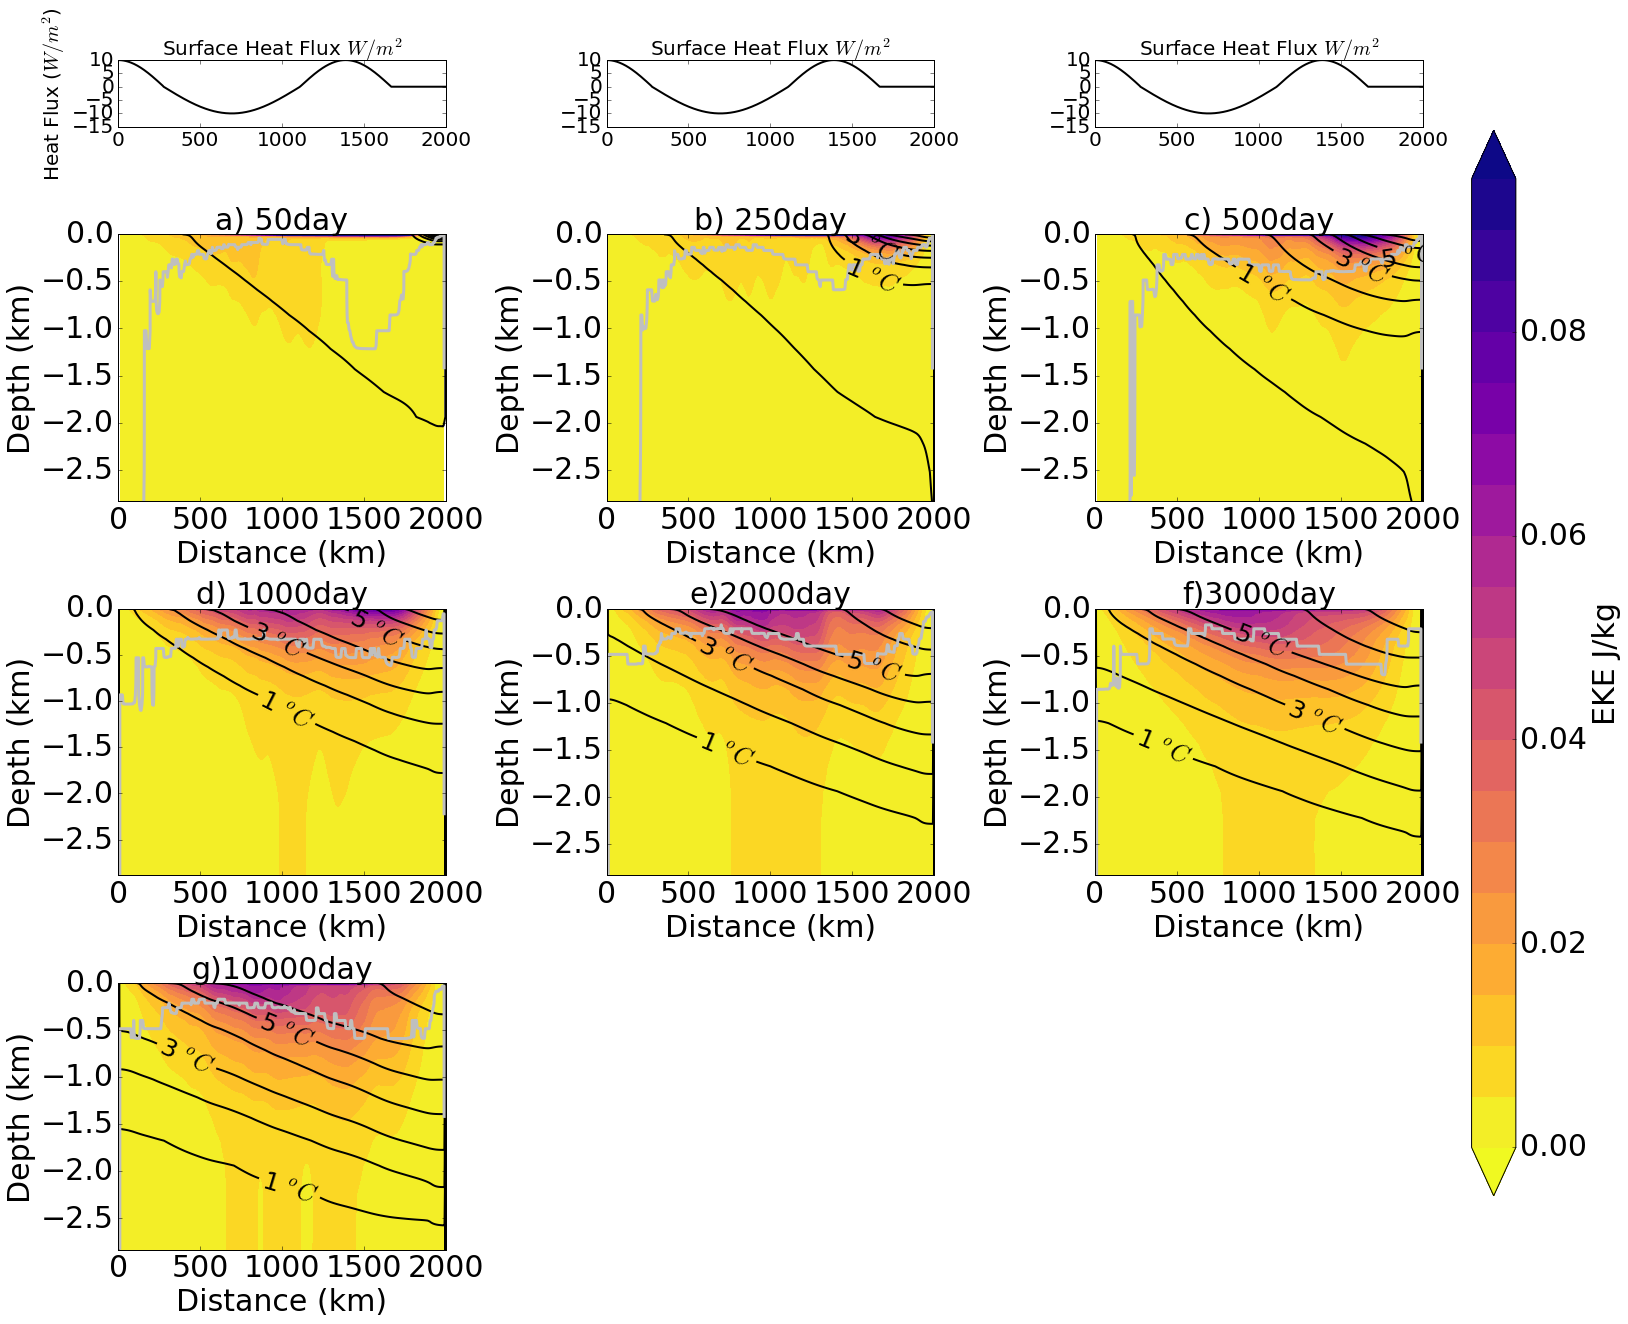

In [34]:
EKEt = []
EKEm = []
fig = plt.figure(figsize=(20.5, 18.5))
# Create Panels
Psi_levs = np.arange(-0., .1, .005)
Psi_ticks =np.arange(-0., .1, .02)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 4, 4, 4])
ax = plt.subplot(gs[3])
ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
if Full == 'N':
    gs = gridspec.GridSpec(4, 3, height_ratios=[1, 4, 4,4])
    ax = plt.subplot(gs[0])
    ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[2])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'m/'

    c = utils.ChannelSetup(output_dir=str(fname))
    g = layers_calc_numba.LayersComputer(c)
    # PLOT PANNELS
    EKE = c.calc_EKE()
    CellVol =np.tile(c.dzf,(c.Ny,1)).T/c.H
    EKEt.append(np.sum(np.sum(EKE*CellVol,axis=0)))
    EKEm.append(np.max(EKE))
    ax = plt.subplot(gs[3+i])
    Q2_levs = (np.arange(-1,8,1))
    p = ax.contourf(c.yc/1000, c.zc/1000,
                EKE, Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')

    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    PIz = g.transform_g_to_z(PI,th)
    PIz[-5::,50::]=np.nan
    r = ax.contour(c.yg/1000,c.zc/1000, PIz,[0.99999999], colors='0.75', linewidths=3)
    #r = ax.plot(c.yc/1000,SG.savitzky_golay(-DDL/1000,21,1),scalex=False,scaley=False, color='0.75', linewidth=4)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('EKE J/kg', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

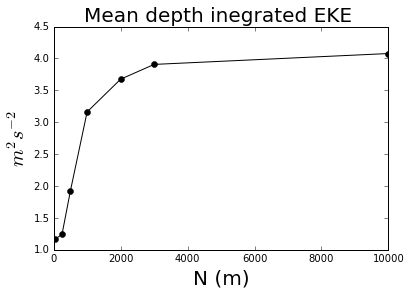

In [35]:
plt.plot([50,250,500,1000,2000,3000,10000],EKEt,'-ko')
plt.xlabel('N (m)', fontsize=20)
plt.ylabel(r'$m^2s^{-2}$', fontsize=20)
plt.title('Mean depth inegrated EKE ', fontsize=20)
#plt.ylim(120,300)
#plt.xlim(0,2*10**5)

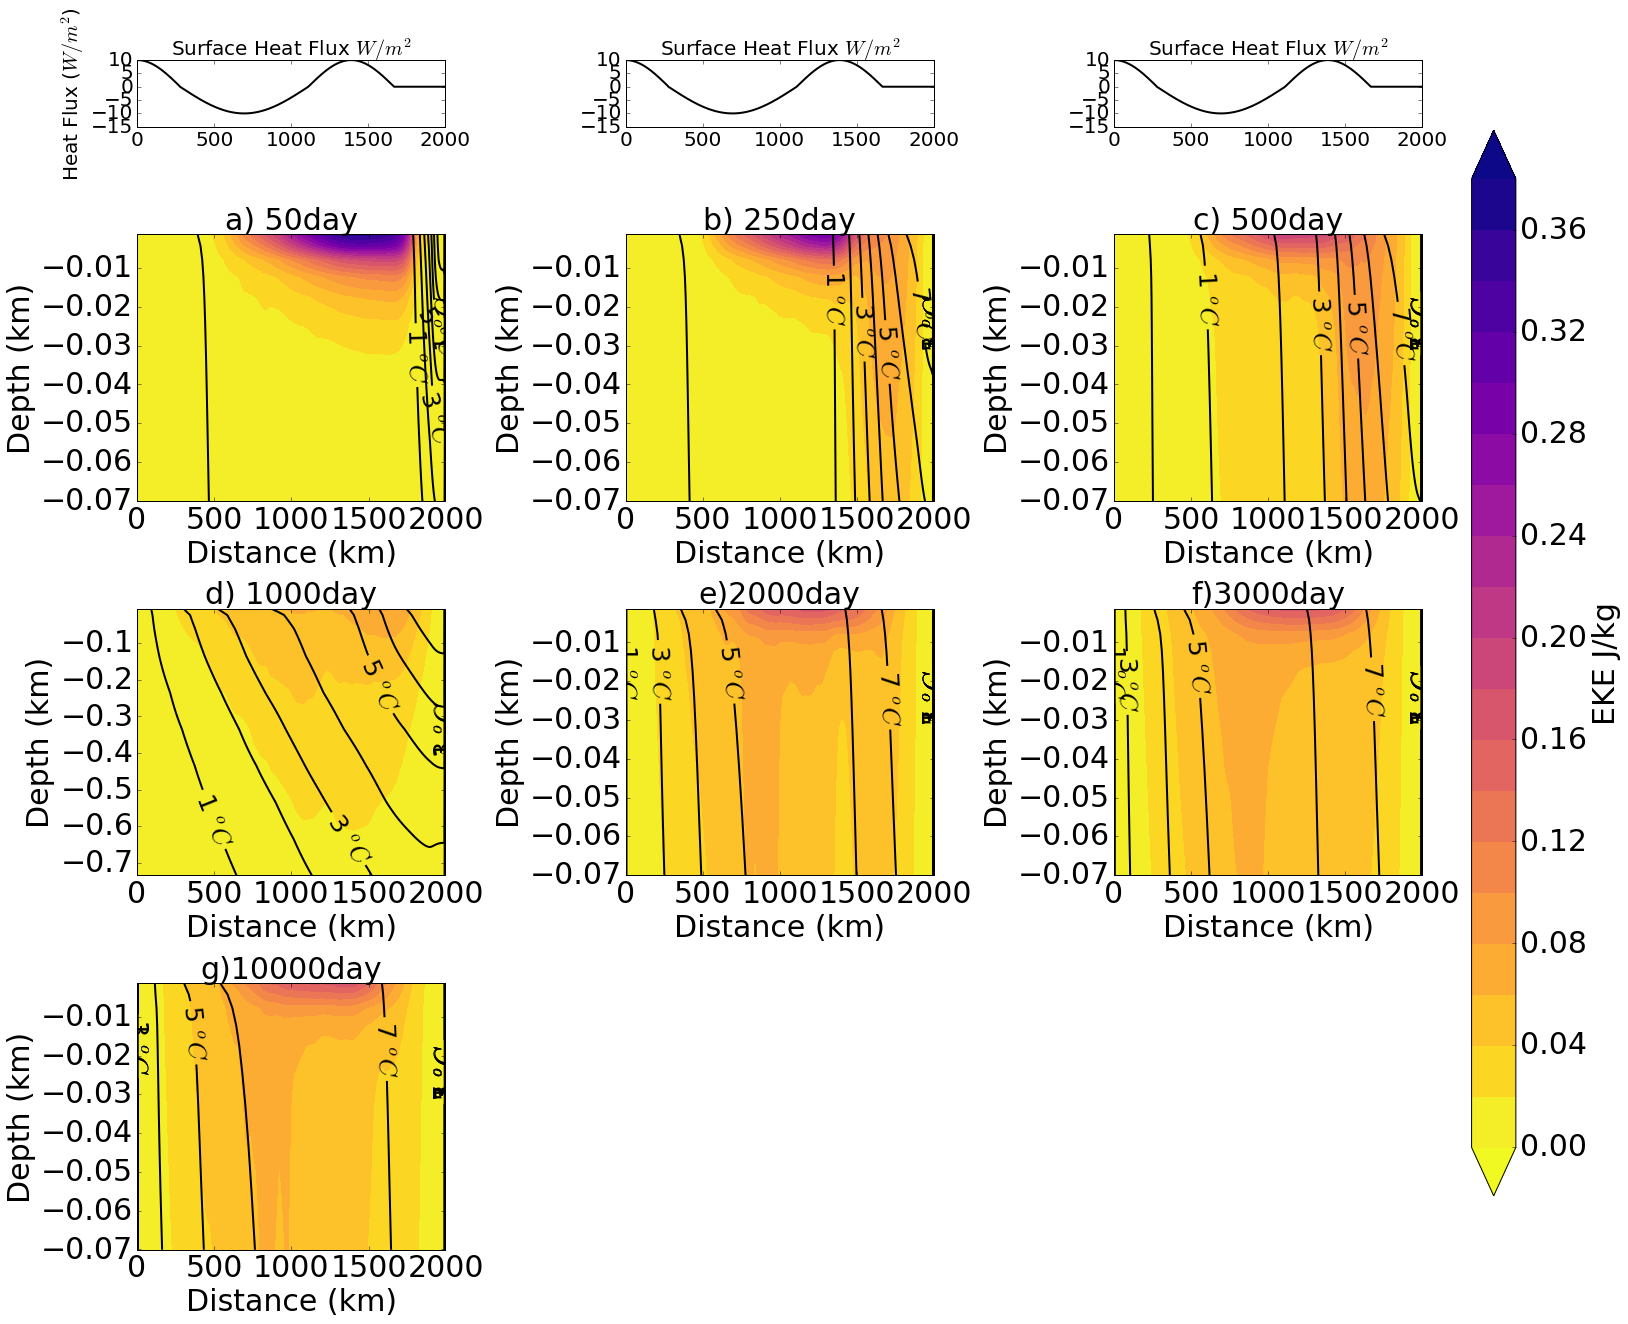

In [28]:
fig = plt.figure(figsize=(20.5, 18.5))
# Create Panels
Psi_levs = np.arange(-0., .4, .02)
Psi_ticks =np.arange(-0., .4, .04)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 4, 4, 4])
ax = plt.subplot(gs[3])
ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
if Full == 'N':
    gs = gridspec.GridSpec(4, 3, height_ratios=[1, 4, 4,4])
    ax = plt.subplot(gs[0])
    ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[2])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'m/'

    c = utils.ChannelSetup(output_dir=str(fname))
    g = layers_calc_numba.LayersComputer(c)
    # PLOT PANNELS
    EKE = c.calc_EKE()
    ax = plt.subplot(gs[3+i])
    Q2_levs = (np.arange(-1,8,1))
    p = ax.contourf(c.yc/1000, c.zc[0:10]/1000,
                EKE[0:10,:], Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')

    q = ax.contour(c.yc/1000, c.zc[0:10]/1000, Tavlat[0:10,:], Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('EKE J/kg', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

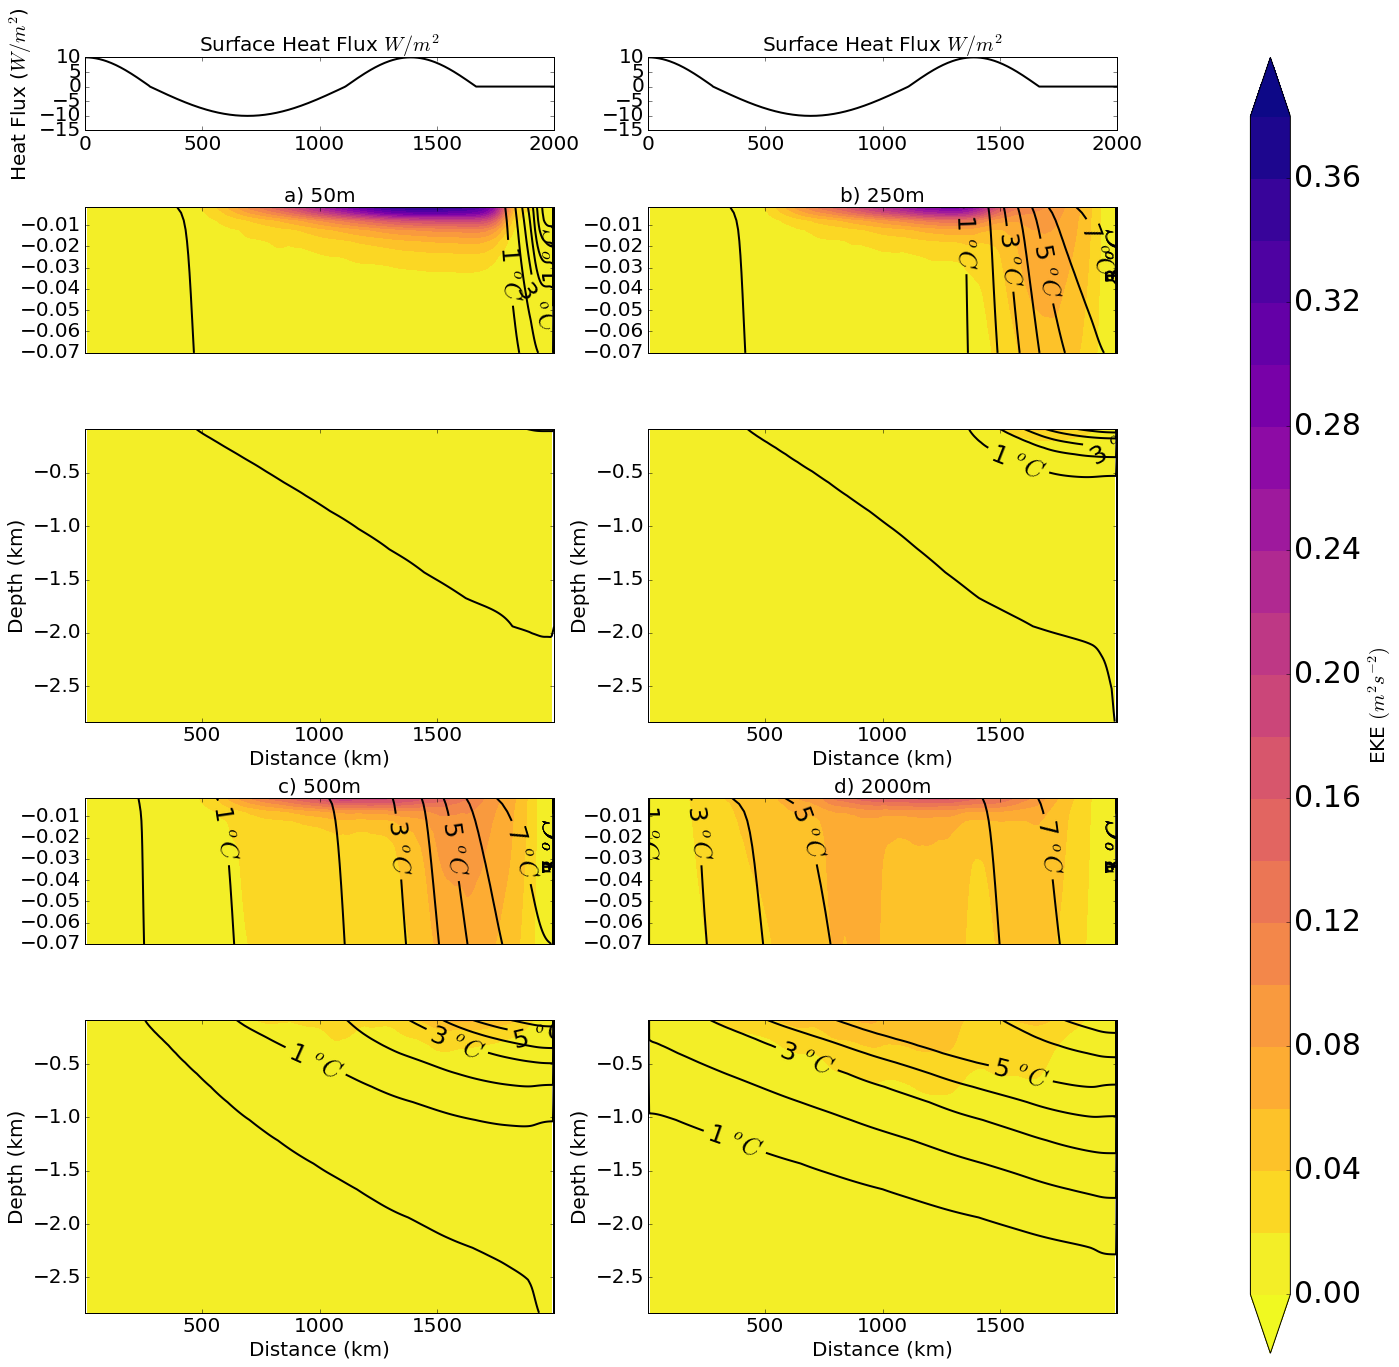

In [17]:
fig = plt.figure(figsize=(18.5, 22.5))
# Create Panels

Psi_levs = np.arange(-0., .4, .02)
Psi_ticks =np.arange(-0., .4, .04)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(4, 4, height_ratios=[1, 2, 4, 4])
ax = plt.subplot(gs[3])
ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
if Full == 'N':
    gs = gridspec.GridSpec(5, 2, height_ratios=[1, 2, 4, 2, 4])
    ax = plt.subplot(gs[0])
    ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'m/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    EKE = c.calc_EKE()
    if i <= 1:
        pos = 2
    else:
        pos = 4
    gs.update(hspace=0.4)
    ax = plt.subplot(gs[pos+i])
    Q2_levs = (np.arange(-1,8,1))
    p = ax.contourf(c.yc/1000, c.zc[0:10]/1000,
                EKE[0:10,:], Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')
    q = ax.contour(c.yc/1000, c.zc[0:10]/1000, Tavlat[0:10,:], Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'m', fontsize=20)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(bottom='off',labelbottom='off')
    #gs.update(hspace=0.05)
    ax2 = plt.subplot(gs[2+pos+i])
    p = ax2.contourf(c.yc/1000, c.zc[10::]/1000,
                EKE[10::,:], Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    q = ax2.contour(c.yc/1000, c.zc[10::]/1000, Tavlat[10::], Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)

  
    ax2.set_xlabel('Distance (km)', fontsize=20)
    ax2.set_ylabel('Depth (km)', fontsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=20)
#plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('EKE $(m^2s^{-2})$', fontsize=20, )
cbar.ax.tick_params(labelsize=30)

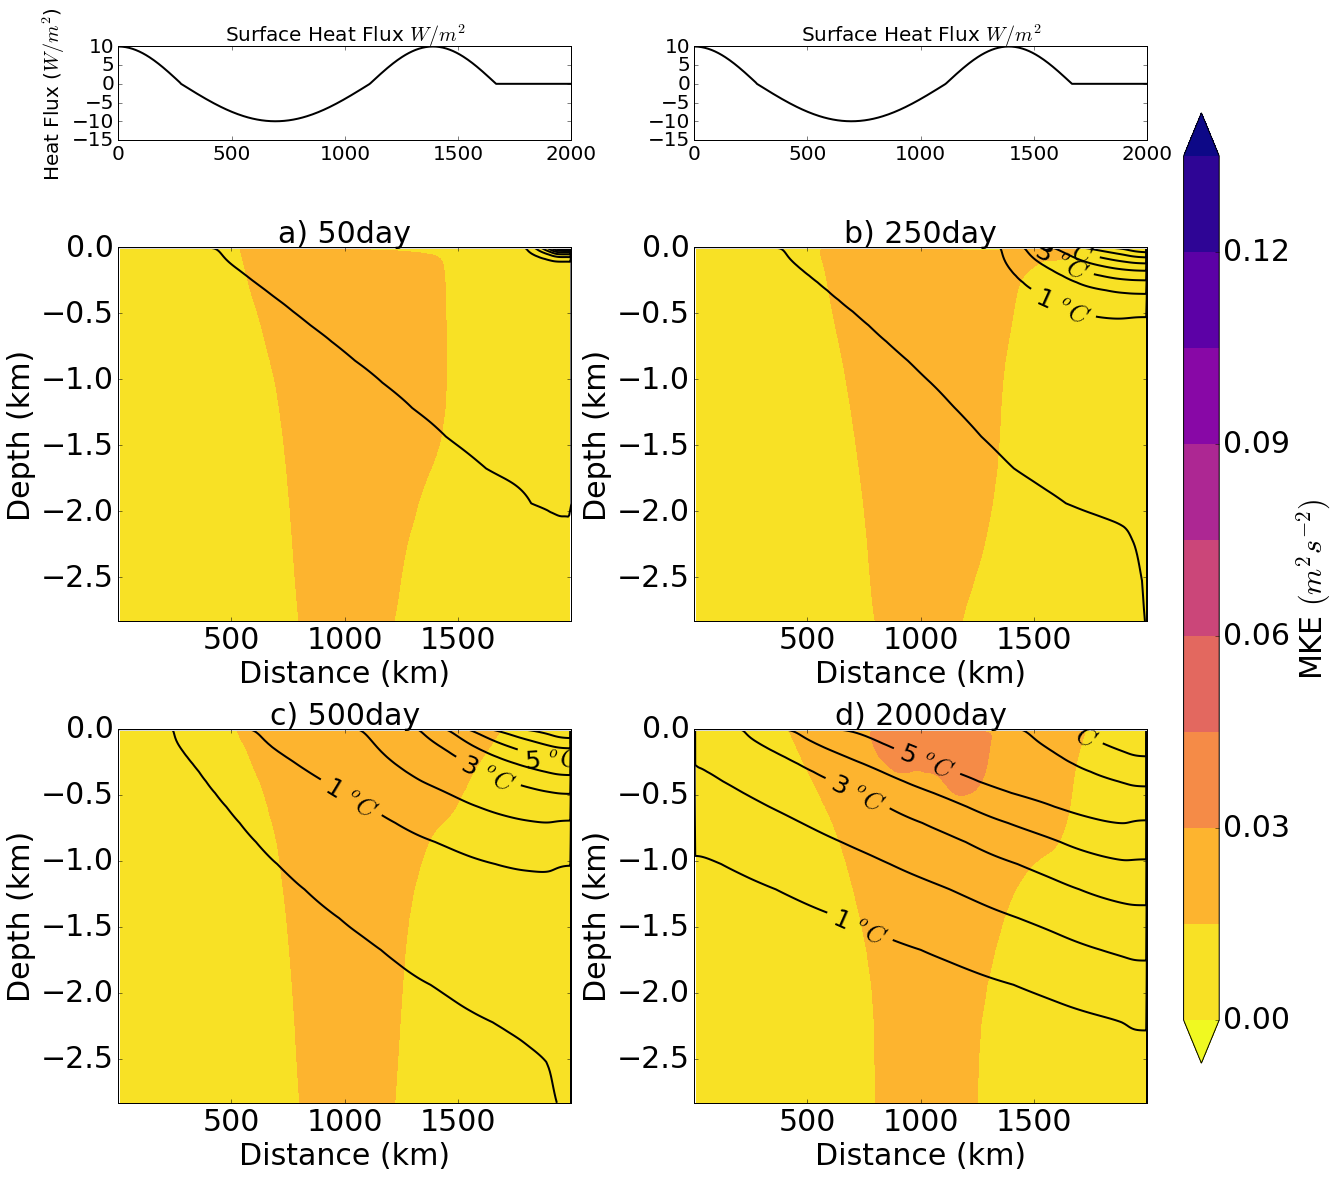

In [6]:
fig = plt.figure(figsize=(16.5, 16.5))
# Create Panels
MKEt = []
Psi_levs = np.arange(-0., .15, .015)
Psi_ticks =np.arange(-0., .15, .03)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 4, 4, 4])
ax = plt.subplot(gs[3])
ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
if Full == 'N':
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    #i=1
    fname = x+'/'+str(tau[Runs[i]])+'m/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    EKE = c.calc_MKE()
    ax = plt.subplot(gs[2+i])
    Q2_levs = (np.arange(-1,8,1))
    p = ax.contourf(c.yc/1000, c.zc/1000,
                EKE,Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')
    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs, colors='k', linewidths=2)

   
    r = ax.plot(c.yc/1000,SG.savitzky_golay(-DDL/1000,21,1),scalex=False,scaley=False, color='0.85', linewidth=4)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('MKE $(m^2s^{-2})$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

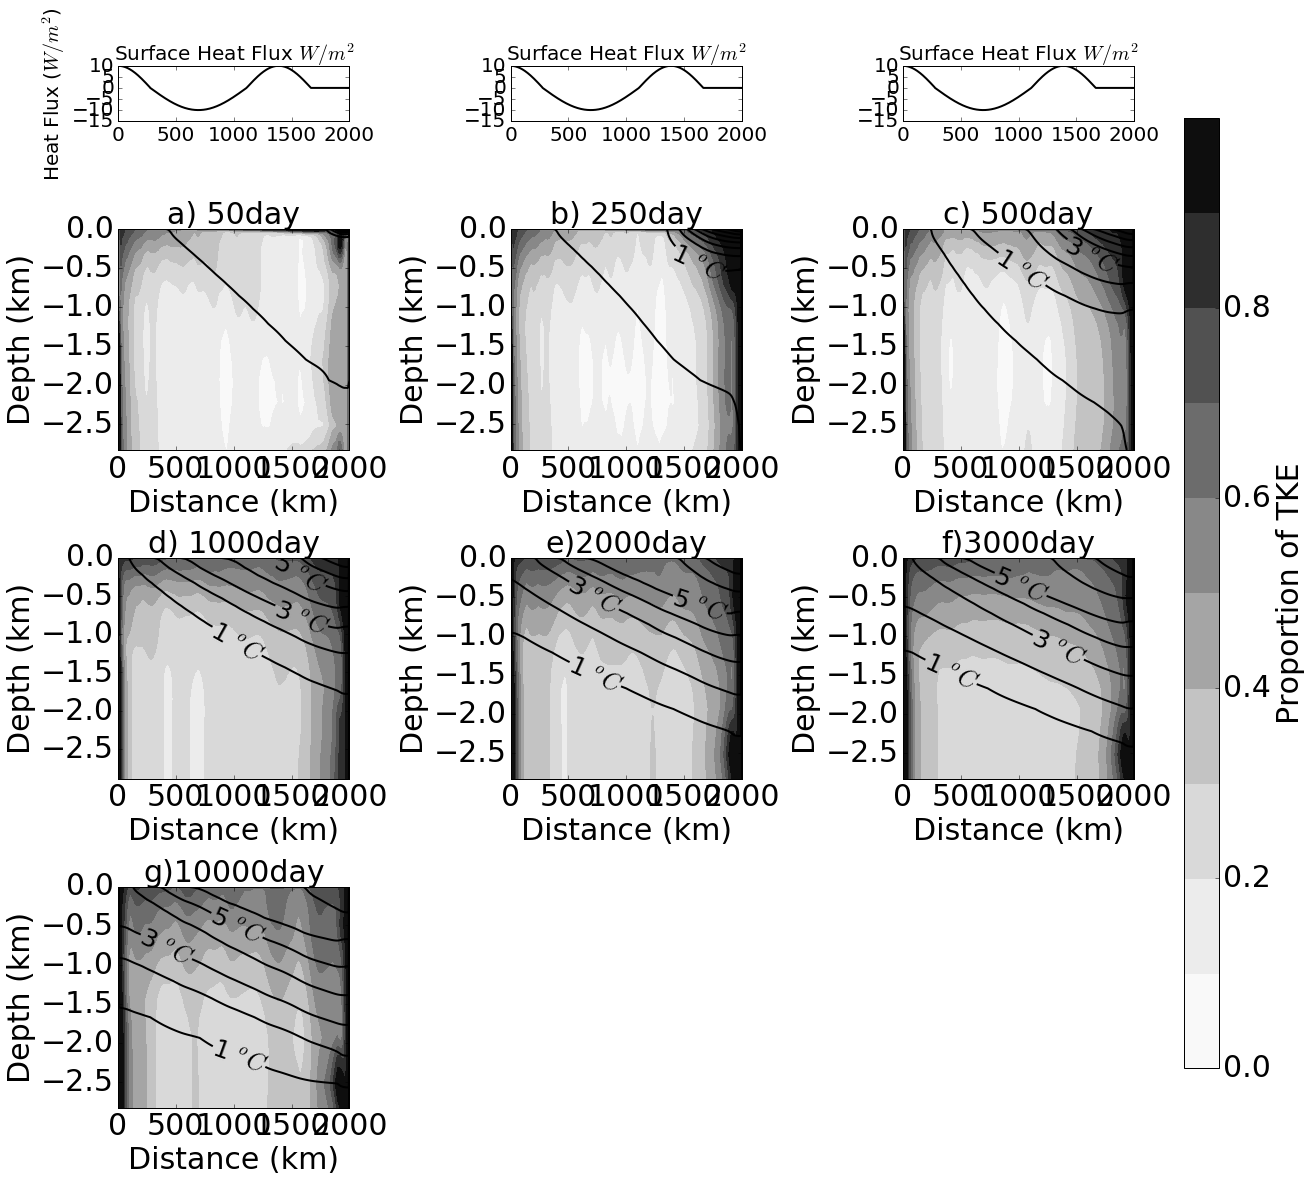

In [29]:
fig = plt.figure(figsize=(16.5, 16.5))
# Create Panels
TKEt=[]
EKEt=[]
APEt = []
Psi_levs = np.arange(-0.,1.1, .1)
Psi_ticks =np.arange(-0., 1., .2)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 4, 4, 4])
ax = plt.subplot(gs[3])
ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
if Full == 'N':
    gs = gridspec.GridSpec(4, 3, height_ratios=[1, 4, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[2])
    ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    #i=1

    fname = x+'/'+str(tau[Runs[i]])+'m/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    TKE = c.calc_EKE()/(c.calc_MKE()+c.calc_EKE())
    CellVol = 5000*5000*1000*np.tile(c.dzf,(c.Nx,c.Ny,1)).T/c.Nx
    TKEt.append(np.sum((c.calc_MKE_all()+c.calc_EKE_all())*CellVol))#/np.sum(CellVol))
    EKEt.append(np.sum(c.calc_EKE_all()*CellVol))#/np.sum(CellVol))
    g = AC.APEcomputer(c)
    APE = g.calc_APE()
    APEt.append(np.sum(APE))#/np.sum(CellVol))
    ax = plt.subplot(gs[3+i])
    Q2_levs = (np.arange(-1,8,1))
    p = ax.contourf(c.yc/1000, c.zc/1000,
                TKE,Psi_levs, cmap=plt.cm.Greys)
    
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')
   
    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
   
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('Proportion of TKE', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

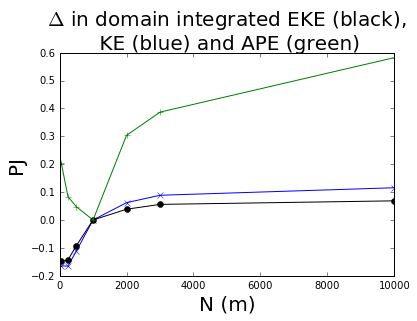

In [31]:
plt.plot([50,250,500,1000,2000, 3000, 10000],(TKEt-TKEt[3])*10**-15,'-bx')
plt.plot([50,250,500,1000,2000, 3000, 10000],(EKEt-EKEt[3])*10**-15,'-ko')
plt.plot([50,250,500,1000,2000, 3000, 10000],(APEt-APEt[3])*10**-15,'-g+')
#plt.ylim(-0.1,13)
plt.xlabel('N (m)', fontsize=20)
plt.ylabel(r'PJ', fontsize=20)
plt.title("$\Delta$ in domain integrated EKE (black),\n KE (blue) and APE (green)", fontsize=20)

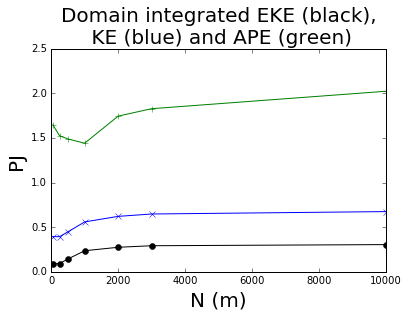

In [32]:
plt.plot([50,250,500,1000,2000, 3000, 10000],np.array(TKEt)*10**-15,'-bx')
plt.plot([50,250,500,1000,2000, 3000, 10000],np.array(EKEt)*10**-15,'-ko')
plt.plot([50,250,500,1000,2000, 3000, 10000],np.array(APEt)*10**-15,'-g+')
plt.xlabel('N (m)', fontsize=20)
plt.ylabel(r'PJ', fontsize=20)
plt.title('Domain integrated EKE (black),\n KE (blue) and APE (green)', fontsize=20)
#plt.ylim(120,300)
#plt.xlim(0,2*10**5)

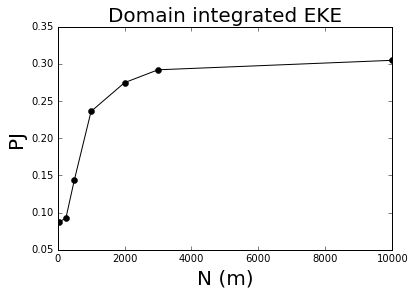

In [33]:
plt.plot([50,250,500,1000,2000, 3000, 10000],np.array(EKEt)*10**-15,'-ko')
plt.xlabel('N (m)', fontsize=20)
plt.ylabel(r'PJ', fontsize=20)
plt.title(r'Domain integrated EKE', fontsize=20)